In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *
from gridsearch import grid_search

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [6]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [7]:
from sklearn.preprocessing import MinMaxScaler
rescaler = MinMaxScaler()
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
rescaler.fit(y_train)
y_train = rescaler.transform(y_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [ ]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-3)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=16,
    starting=Range_random(),
    regularizer=None,
    activation=ReLU(),
)

net.add_layer(
    input_size=16,
    units_size=16,
    starting=Range_random(),
    regularizer=None,
    activation=ReLU(),
)

net.add_layer(
    input_size=16,
    units_size=3,
    starting=Range_random(),
    regularizer=None,
    activation=Identity(),
)

In [ ]:
X_split = np.array_split(X_train, 5)
y_split = np.array_split(y_train, 5)

X_train = np.concatenate(X_split[:4] + (X_split[4 + 1:]))
y_train = np.concatenate(y_split[:4] + (y_split[4 + 1:]))

X_val = X_split[4]
y_val = y_split[4]

In [ ]:
info = net.train(
    X_train, 
    y_train,
    X_val,
    y_val,
    500,
    100,
    MEE()
)
plt.plot(info['tr_losses'], label='Train Loss')
plt.plot(info['val_losses'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(info['tr_metrics'], label='Train Metric')
plt.plot(info['val_metrics'], label='Val Metric')
plt.legend()
plt.show()

In [ ]:
print(net.statistics(X_train, y_train, MEE()))

In [ ]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=2500,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.9) 0.01


Epochs:  22%|██▏       | 2159/10000 [01:10<04:15, 30.70it/s]


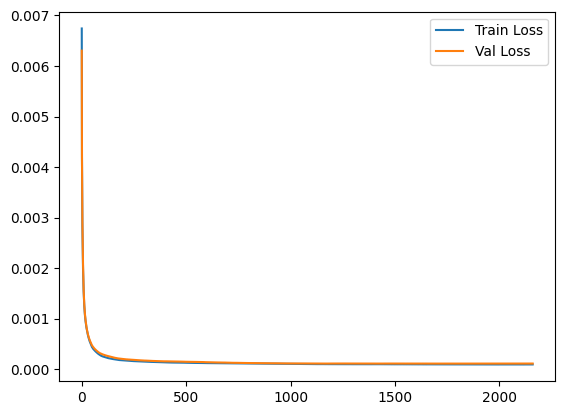

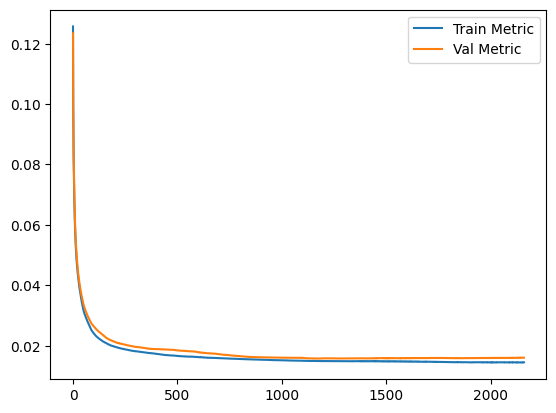

Fold 1 of 6 completed
Train Loss: 9.358456433355613e-05
Train Metric: 0.014481122384651232
Val Loss: 0.00010964253751589194
Val Metric: 0.01587042248027915


Epochs:  25%|██▍       | 2496/10000 [01:21<04:03, 30.76it/s]


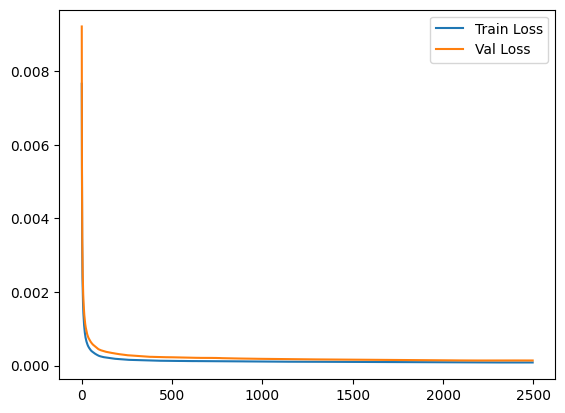

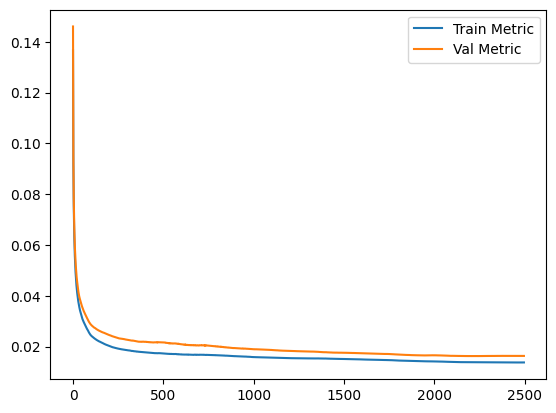

Fold 2 of 6 completed
Train Loss: 8.639344861371192e-05
Train Metric: 0.013810714795953409
Val Loss: 0.00013928484011493334
Val Metric: 0.01628660140741285


Epochs:  34%|███▍      | 3422/10000 [01:51<03:33, 30.78it/s]


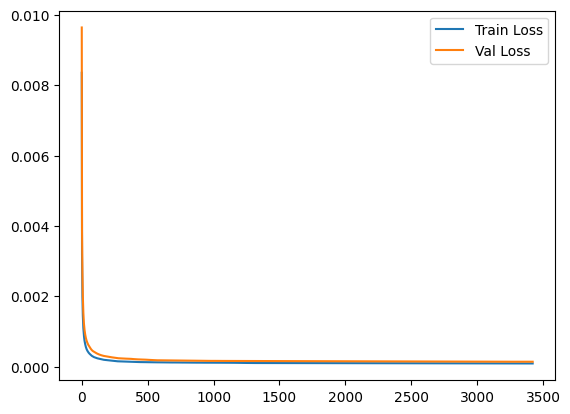

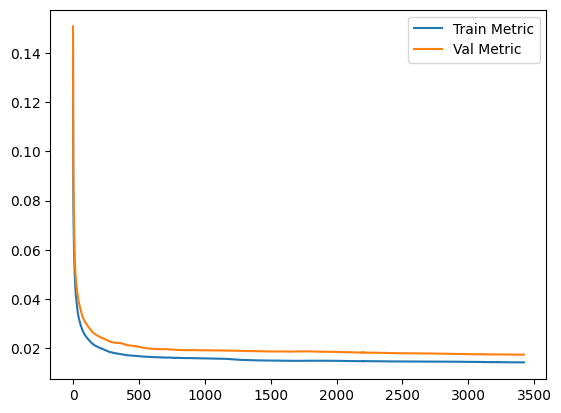

Fold 3 of 6 completed
Train Loss: 9.125482871195766e-05
Train Metric: 0.01438725488901186
Val Loss: 0.0001392085112892616
Val Metric: 0.01748748288233295


Epochs:  17%|█▋        | 1742/10000 [00:56<04:29, 30.69it/s]


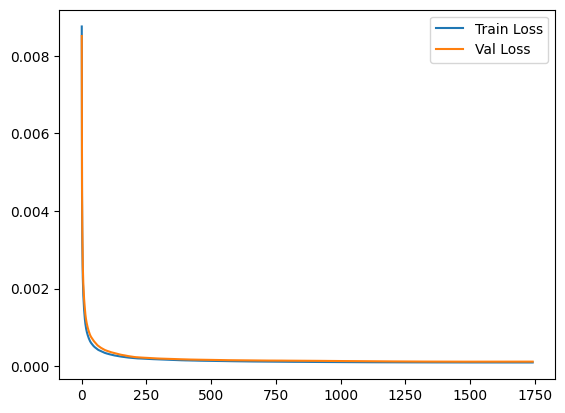

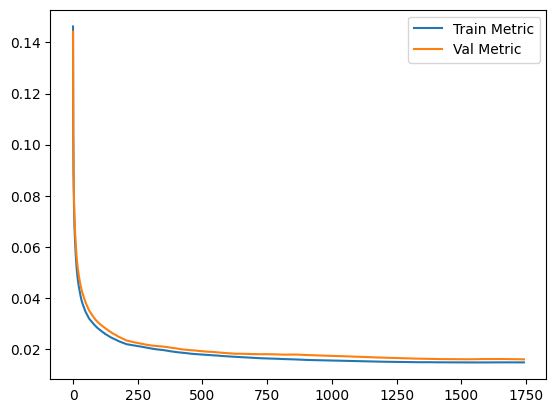

Fold 4 of 6 completed
Train Loss: 9.498127070308163e-05
Train Metric: 0.014799564935665008
Val Loss: 0.00011507291805960537
Val Metric: 0.01601759553500308


Epochs:  31%|███▏      | 3129/10000 [01:42<03:44, 30.66it/s]


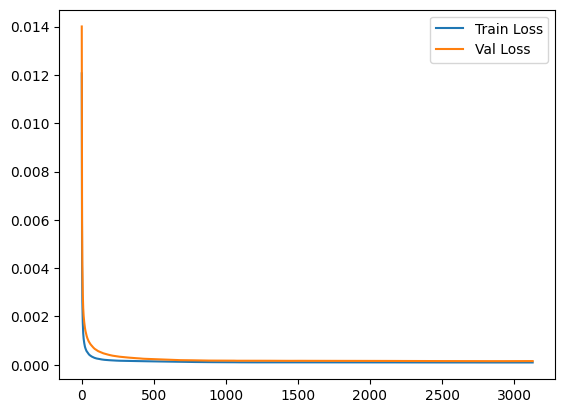

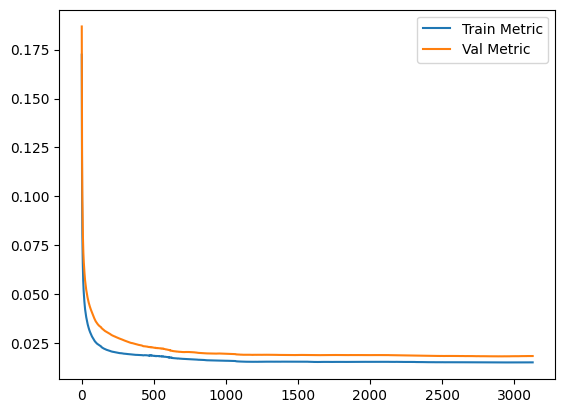

Fold 5 of 6 completed
Train Loss: 9.655977879528044e-05
Train Metric: 0.015043599286949458
Val Loss: 0.000151441890282534
Val Metric: 0.01817090793180026


Epochs:  57%|█████▋    | 5704/10000 [03:05<02:19, 30.80it/s]


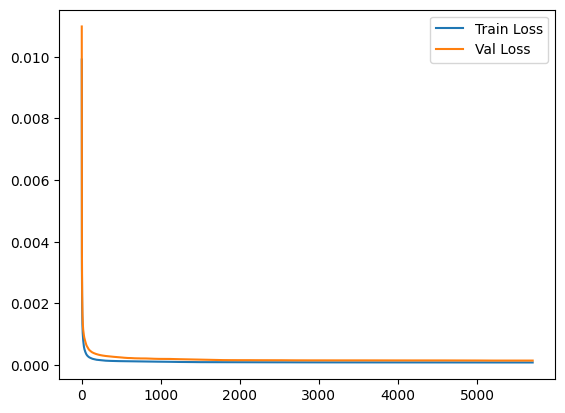

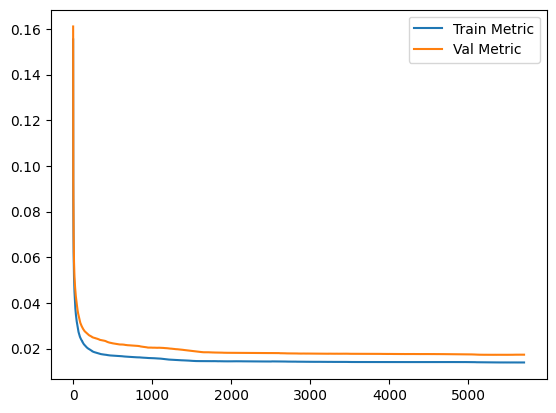

Fold 6 of 6 completed
Train Loss: 8.563988247705352e-05
Train Metric: 0.013909147750124598
Val Loss: 0.0001465730351683406
Val Metric: 0.017258279884167494
Statistics: {'tr_loss': 9.140229560577356e-05, 'tr_metric': 0.01440523400705926, 'val_loss': 0.0001335372887384278, 'val_metric': 0.016848548353499297}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.9) 0.001


Epochs:   8%|▊         | 758/10000 [00:24<04:58, 30.92it/s]


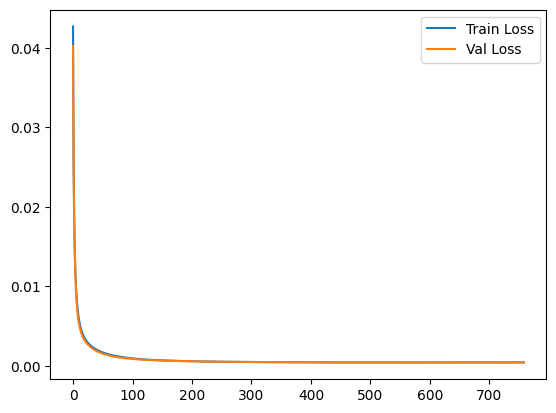

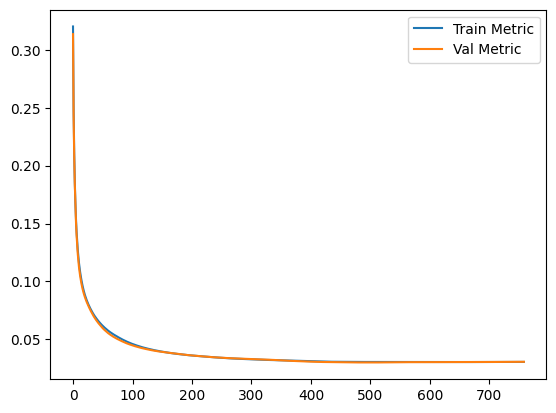

Fold 1 of 6 completed
Train Loss: 0.00041878658103518057
Train Metric: 0.030497113097280436
Val Loss: 0.00041986110653937633
Val Metric: 0.030048114995458848


Epochs:  12%|█▏        | 1230/10000 [00:41<04:57, 29.48it/s]


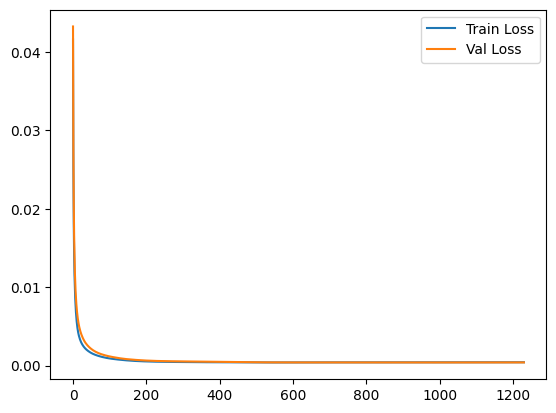

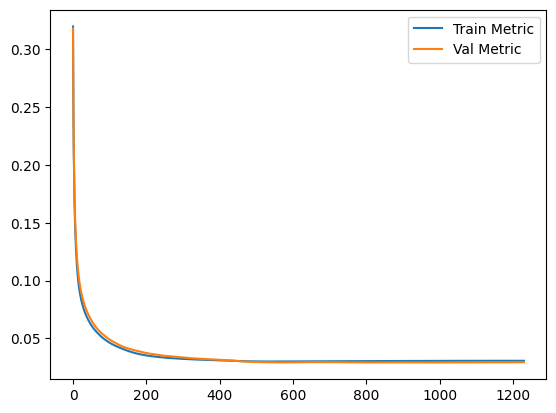

Fold 2 of 6 completed
Train Loss: 0.00042684341807801187
Train Metric: 0.030470914339841882
Val Loss: 0.0004029817088474459
Val Metric: 0.029140403612872692


Epochs:   9%|▉         | 892/10000 [00:38<06:30, 23.30it/s]  


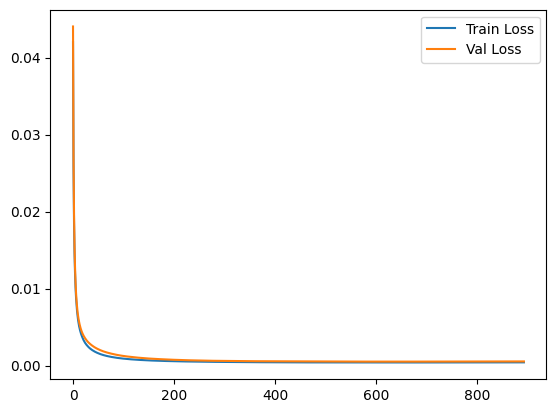

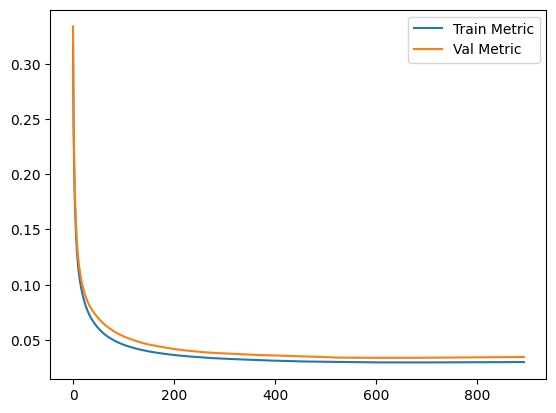

Fold 3 of 6 completed
Train Loss: 0.00040814316206676184
Train Metric: 0.029663798557736782
Val Loss: 0.0005177033610883761
Val Metric: 0.033843479529301244


Epochs:   9%|▉         | 909/10000 [00:29<04:54, 30.86it/s]


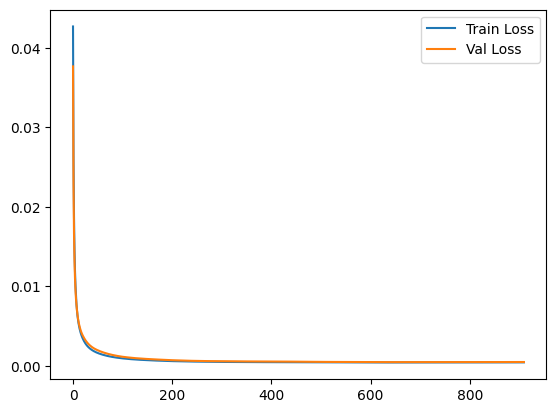

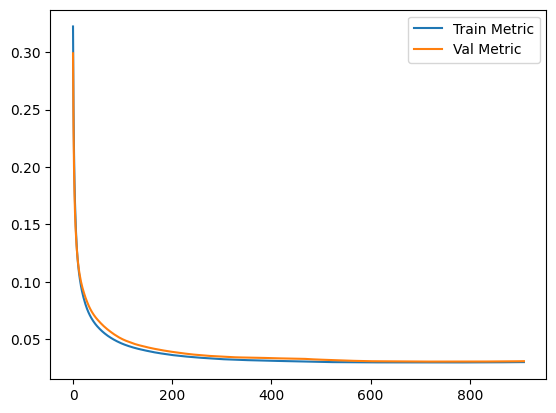

Fold 4 of 6 completed
Train Loss: 0.00040474673301253987
Train Metric: 0.029889072050416014
Val Loss: 0.00044723777329149536
Val Metric: 0.030647501473429803


Epochs:  12%|█▏        | 1190/10000 [00:38<04:46, 30.79it/s]


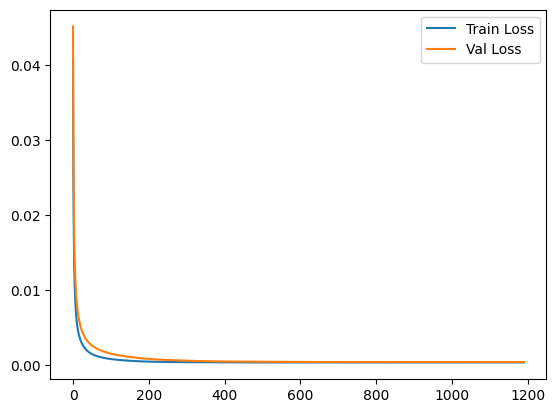

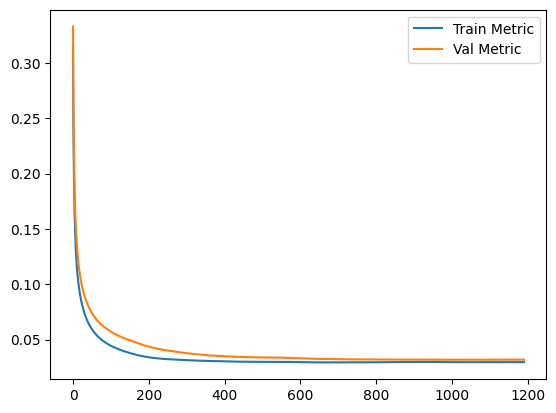

Fold 5 of 6 completed
Train Loss: 0.00040737168896144455
Train Metric: 0.029681240813703342
Val Loss: 0.0004455637862650189
Val Metric: 0.03180053789785782


Epochs:   9%|▉         | 939/10000 [00:30<04:56, 30.56it/s]


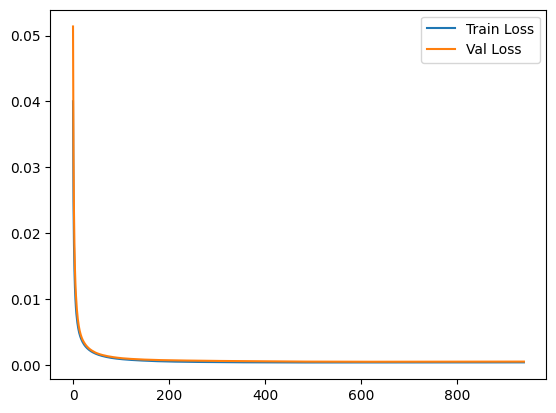

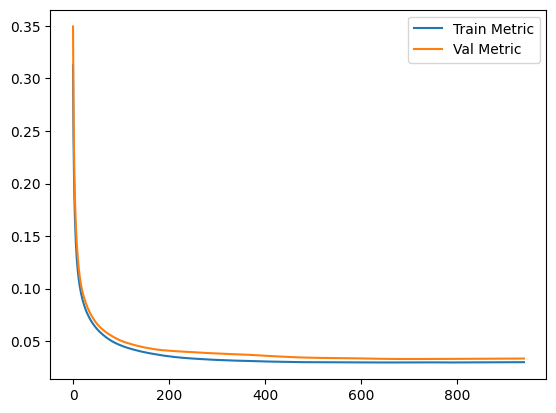

Fold 6 of 6 completed
Train Loss: 0.0004086281155937323
Train Metric: 0.029726127042159243
Val Loss: 0.0005112270498477463
Val Metric: 0.03301797942158589
Statistics: {'tr_loss': 0.0004124199497912785, 'tr_metric': 0.029988044316856283, 'val_loss': 0.0004574291309799099, 'val_metric': 0.031416336155084386}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.9) 0.01


Epochs:  24%|██▎       | 2351/10000 [01:10<03:48, 33.45it/s]


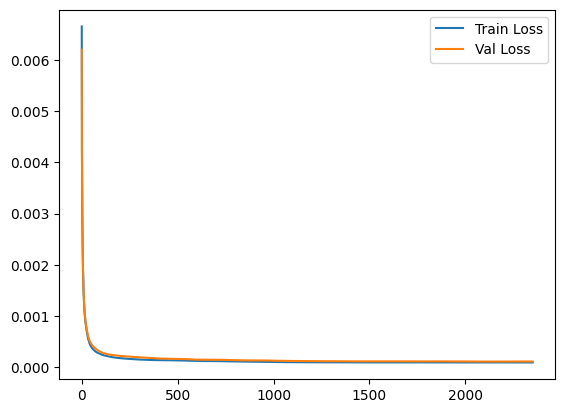

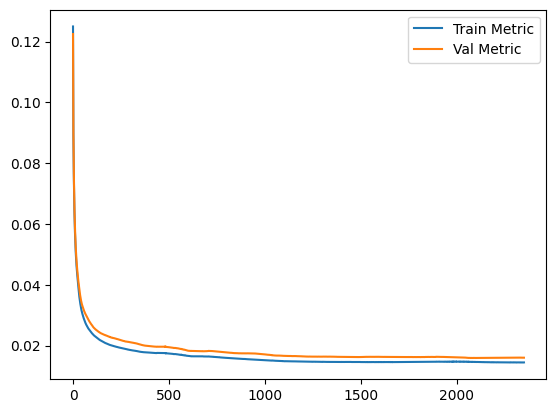

Fold 1 of 6 completed
Train Loss: 9.479861404508683e-05
Train Metric: 0.014593160973315932
Val Loss: 0.0001105444187826081
Val Metric: 0.01589964448009323


Epochs:  36%|███▌      | 3605/10000 [01:45<03:07, 34.08it/s]


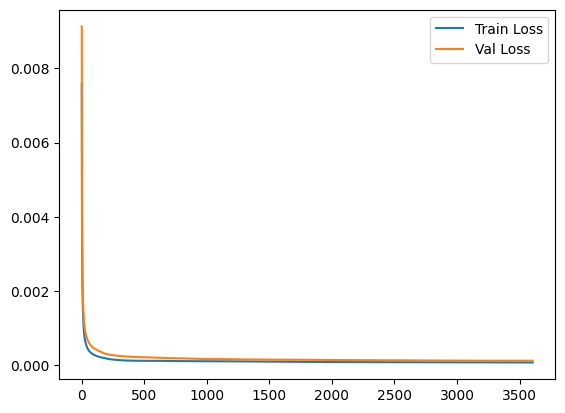

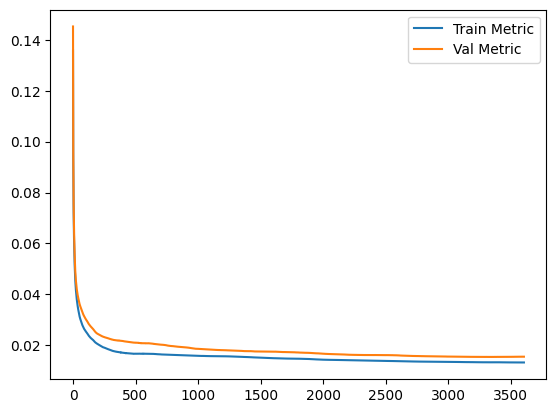

Fold 2 of 6 completed
Train Loss: 7.851718987753186e-05
Train Metric: 0.013276653084317193
Val Loss: 0.0001245104073723658
Val Metric: 0.015387086728029676


Epochs:  14%|█▍        | 1402/10000 [00:41<04:13, 33.96it/s]


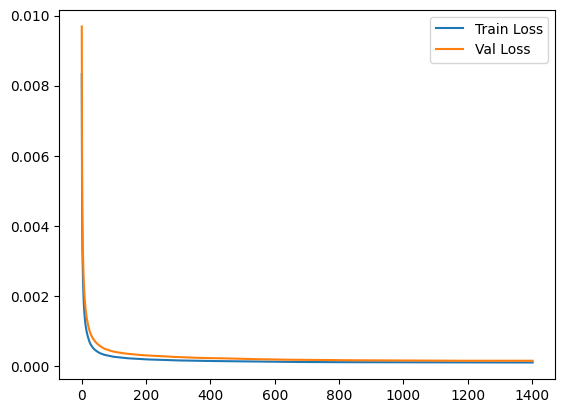

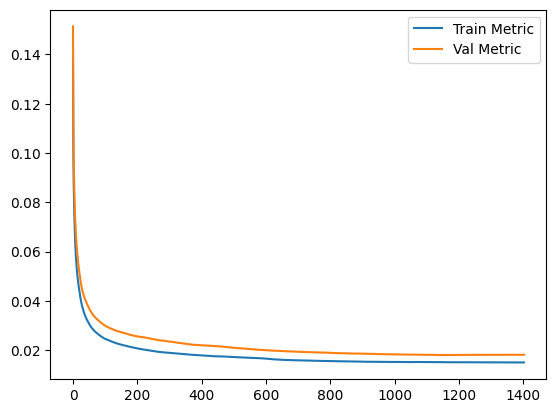

Fold 3 of 6 completed
Train Loss: 0.00010098908155088744
Train Metric: 0.015177814869041567
Val Loss: 0.00014686646453437264
Val Metric: 0.01806816949753687


Epochs:  12%|█▏        | 1216/10000 [00:36<04:20, 33.68it/s]


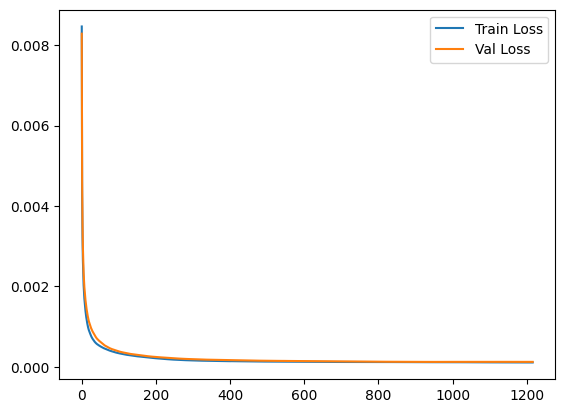

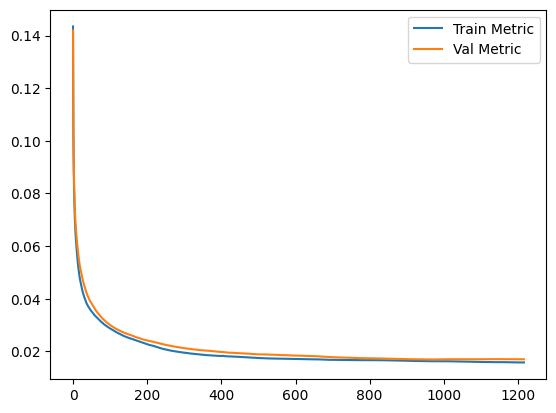

Fold 4 of 6 completed
Train Loss: 0.00011301046154860164
Train Metric: 0.01623618159392881
Val Loss: 0.00012044699887127736
Val Metric: 0.016894047683175144


Epochs:  34%|███▍      | 3445/10000 [01:42<03:14, 33.65it/s]


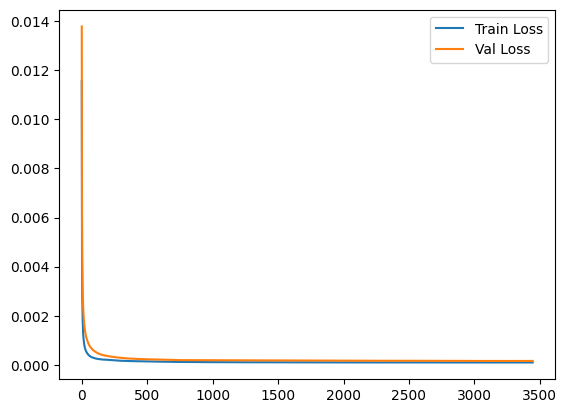

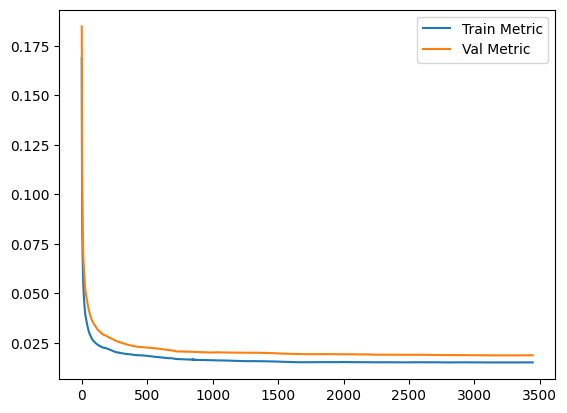

Fold 5 of 6 completed
Train Loss: 9.713711219582029e-05
Train Metric: 0.015056801972283285
Val Loss: 0.00015814437025786967
Val Metric: 0.018630817240911063


Epochs:  27%|██▋       | 2743/10000 [01:21<03:34, 33.82it/s]


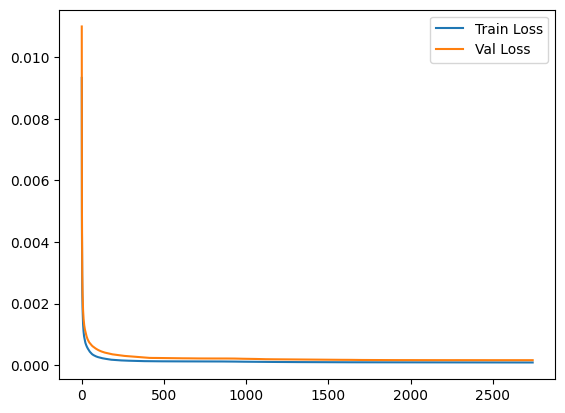

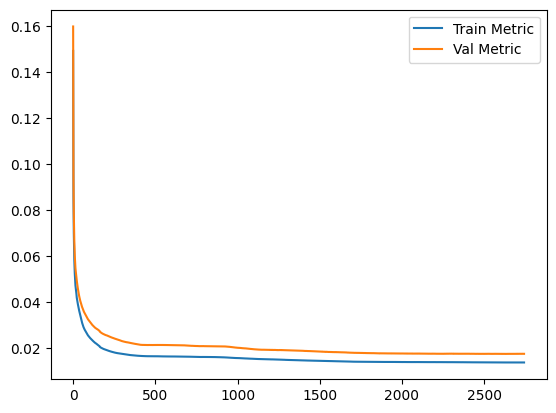

Fold 6 of 6 completed
Train Loss: 8.462998996530462e-05
Train Metric: 0.013838557262035422
Val Loss: 0.00015880812331327813
Val Metric: 0.01752780989656113
Statistics: {'tr_loss': 9.484707486387211e-05, 'tr_metric': 0.014696528292487035, 'val_loss': 0.00013655346385529527, 'val_metric': 0.01706792925438452}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.9) 0.001


Epochs:   7%|▋         | 693/10000 [00:20<04:34, 33.86it/s]


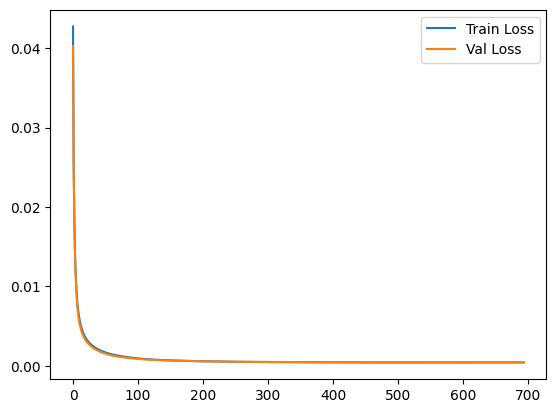

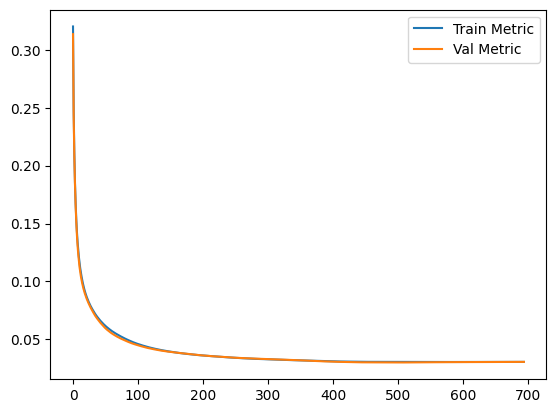

Fold 1 of 6 completed
Train Loss: 0.0004215524785212061
Train Metric: 0.030626978234362442
Val Loss: 0.00041914464746604935
Val Metric: 0.03017100027803869


Epochs:  12%|█▏        | 1241/10000 [00:36<04:19, 33.71it/s]


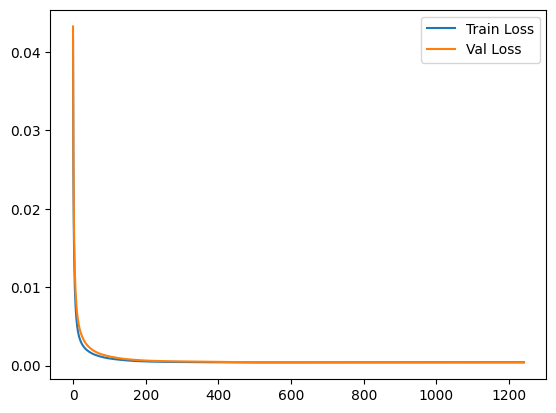

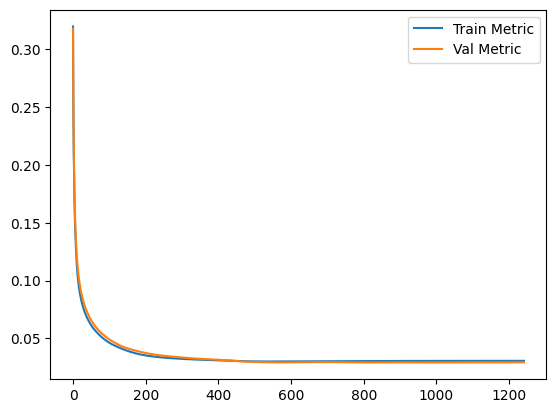

Fold 2 of 6 completed
Train Loss: 0.0004270842982200587
Train Metric: 0.03047478963847124
Val Loss: 0.00040255248226005305
Val Metric: 0.02911258615015657


Epochs:   8%|▊         | 812/10000 [00:24<04:32, 33.71it/s]


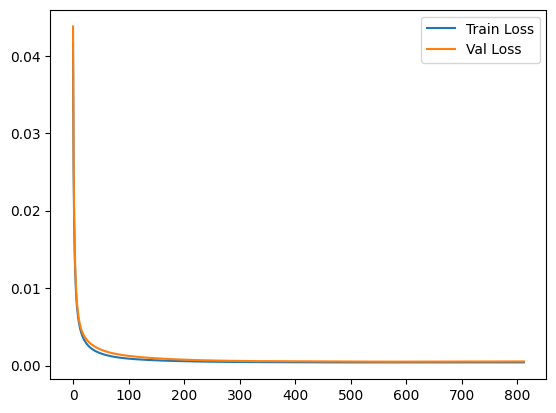

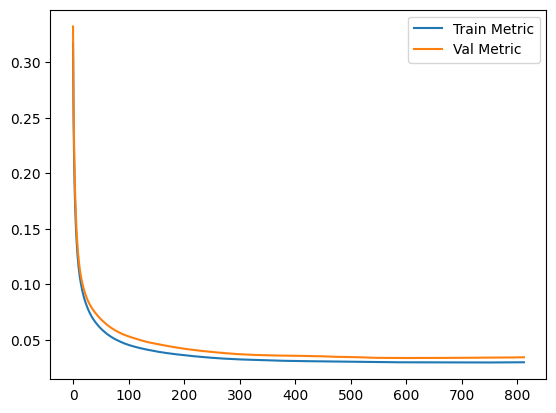

Fold 3 of 6 completed
Train Loss: 0.0004030336998862621
Train Metric: 0.029862554417141425
Val Loss: 0.0005087885550263888
Val Metric: 0.03370579537716557


Epochs:   9%|▉         | 899/10000 [00:26<04:31, 33.52it/s]


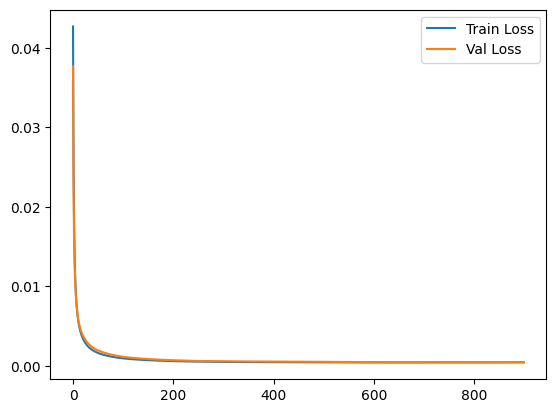

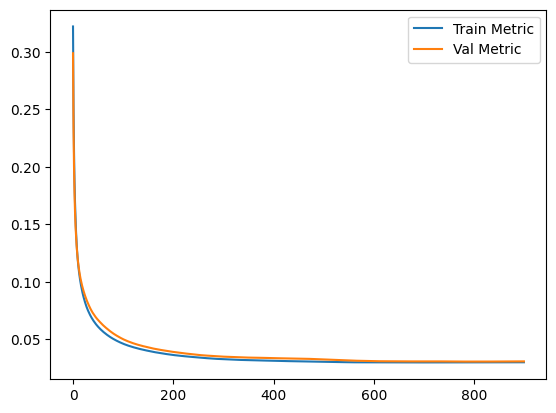

Fold 4 of 6 completed
Train Loss: 0.0004038284327254254
Train Metric: 0.029849022576737008
Val Loss: 0.0004458221177068883
Val Metric: 0.03068846572780003


Epochs:  12%|█▏        | 1192/10000 [00:35<04:23, 33.49it/s]


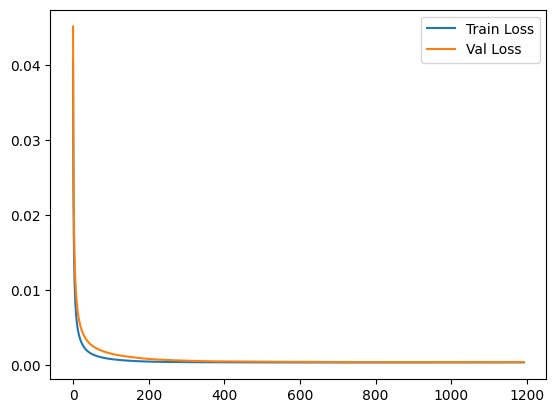

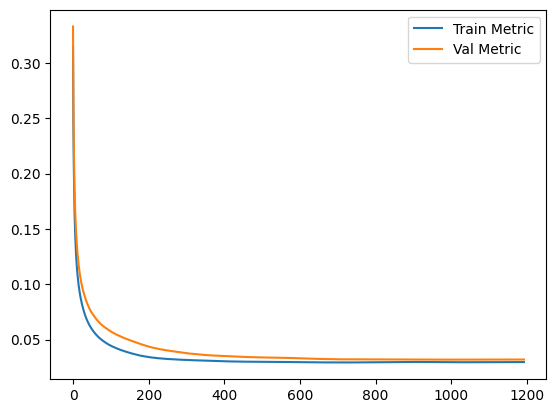

Fold 5 of 6 completed
Train Loss: 0.00040515939336835003
Train Metric: 0.029583939724522865
Val Loss: 0.000446882954826136
Val Metric: 0.03185582876485909


Epochs:   9%|▉         | 943/10000 [00:28<04:31, 33.41it/s]


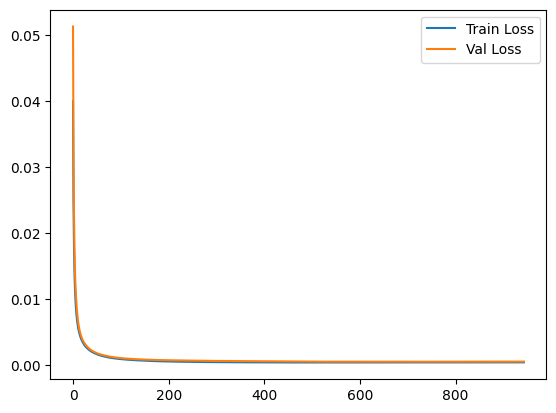

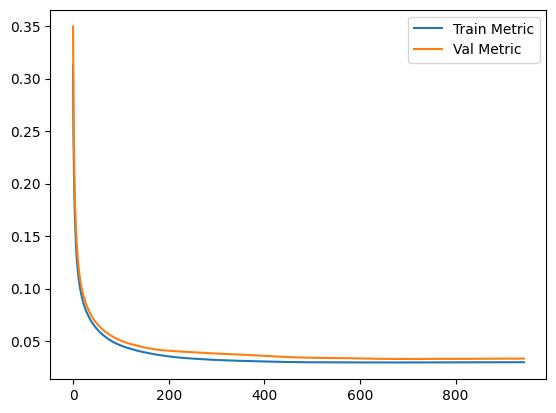

Fold 6 of 6 completed
Train Loss: 0.0004093754821578948
Train Metric: 0.02976687408880122
Val Loss: 0.0005115476363880025
Val Metric: 0.03302448789501209
Statistics: {'tr_loss': 0.0004116722974798662, 'tr_metric': 0.030027359780006035, 'val_loss': 0.00045578973227891964, 'val_metric': 0.031426360698838675}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.01


Epochs:  95%|█████████▍| 9470/10000 [05:08<00:17, 30.70it/s]


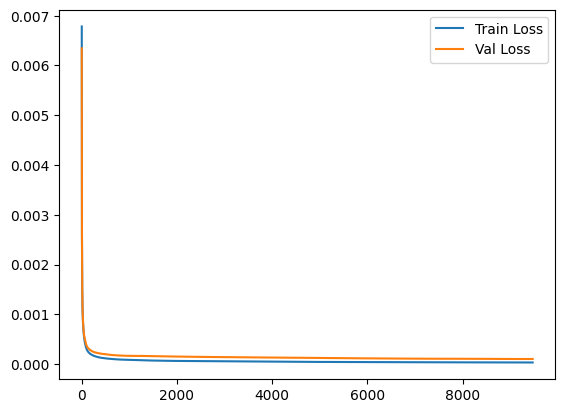

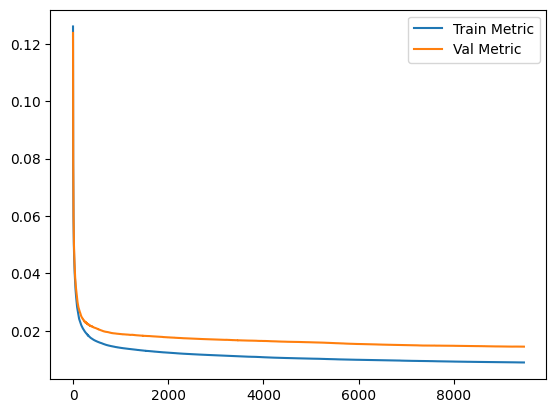

Fold 1 of 6 completed
Train Loss: 3.4253546205244715e-05
Train Metric: 0.00896667173610807
Val Loss: 0.00010338785889852125
Val Metric: 0.01444746253798069


Epochs: 100%|██████████| 10000/10000 [05:25<00:00, 30.75it/s]


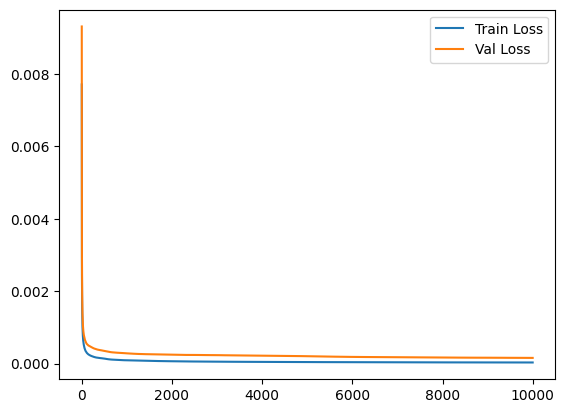

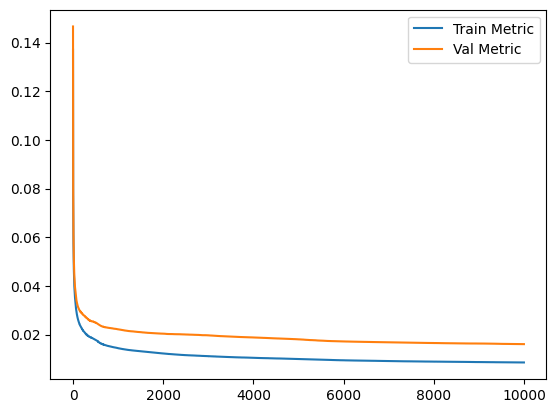

Fold 2 of 6 completed
Train Loss: 3.109705973685279e-05
Train Metric: 0.008567948296945552
Val Loss: 0.0001575804022195975
Val Metric: 0.01610173950863029


Epochs: 100%|██████████| 10000/10000 [05:25<00:00, 30.76it/s]


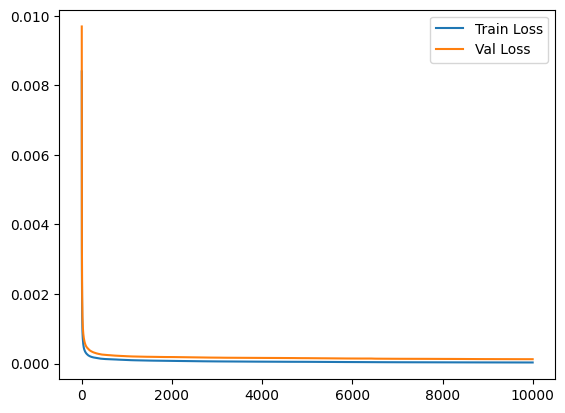

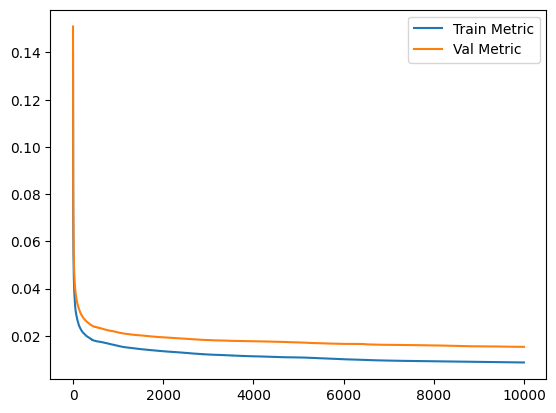

Fold 3 of 6 completed
Train Loss: 3.232708560456236e-05
Train Metric: 0.008718613151132372
Val Loss: 0.00012639743417490376
Val Metric: 0.015334885981948113


Epochs:  71%|███████▏  | 7139/10000 [03:50<01:32, 30.97it/s]


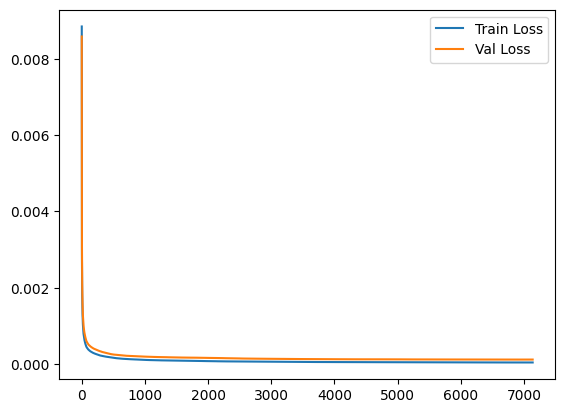

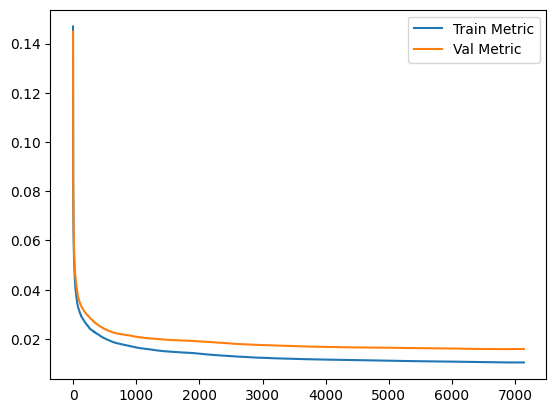

Fold 4 of 6 completed
Train Loss: 4.591857394836734e-05
Train Metric: 0.010430424475221212
Val Loss: 0.00012138543127521775
Val Metric: 0.015852632177821447


Epochs:  62%|██████▏   | 6214/10000 [03:22<02:03, 30.63it/s]


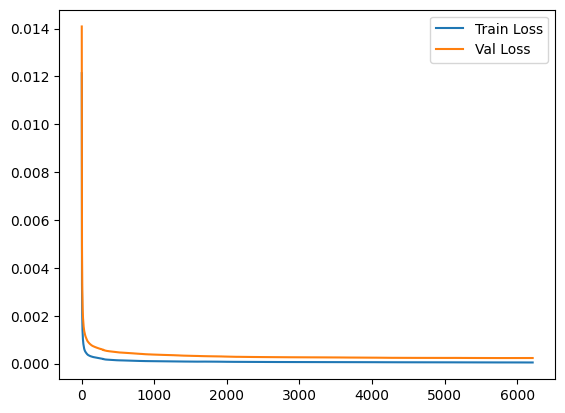

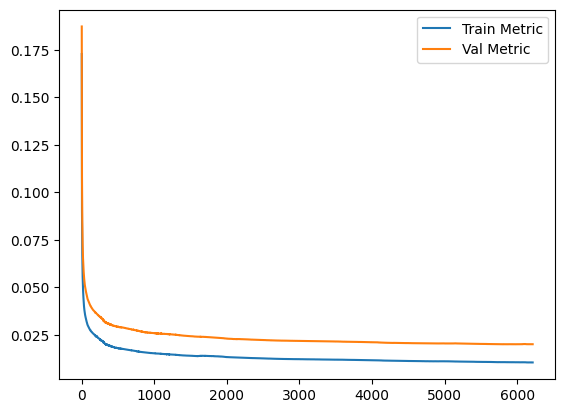

Fold 5 of 6 completed
Train Loss: 4.7001677062427105e-05
Train Metric: 0.01048139622439424
Val Loss: 0.00022936975227852088
Val Metric: 0.019971142824707168


Epochs:  35%|███▍      | 3477/10000 [01:53<03:32, 30.68it/s]


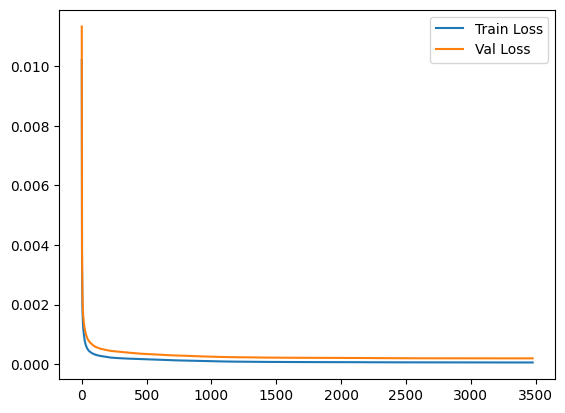

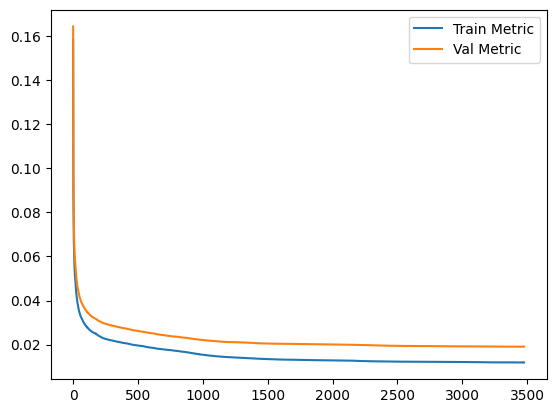

Fold 6 of 6 completed
Train Loss: 6.048578169158046e-05
Train Metric: 0.011954735652264632
Val Loss: 0.0001970521064432496
Val Metric: 0.019058563379843164
Statistics: {'tr_loss': 4.1847287374839136e-05, 'tr_metric': 0.009853298256011013, 'val_loss': 0.00015586216421500178, 'val_metric': 0.01679440440182181}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.001


Epochs: 100%|██████████| 10000/10000 [05:24<00:00, 30.82it/s]


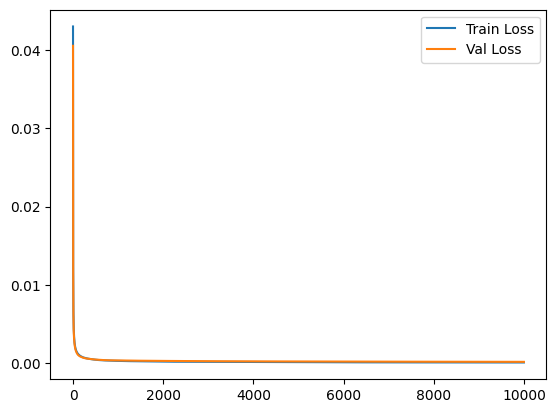

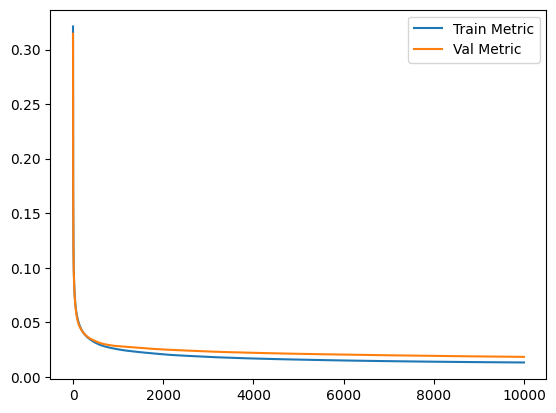

Fold 1 of 6 completed
Train Loss: 7.443304008543661e-05
Train Metric: 0.013146168225560938
Val Loss: 0.00015646367578088632
Val Metric: 0.018291592723008964


Epochs: 100%|██████████| 10000/10000 [05:25<00:00, 30.75it/s]


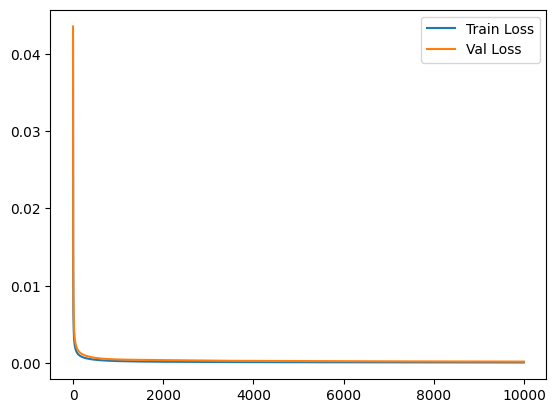

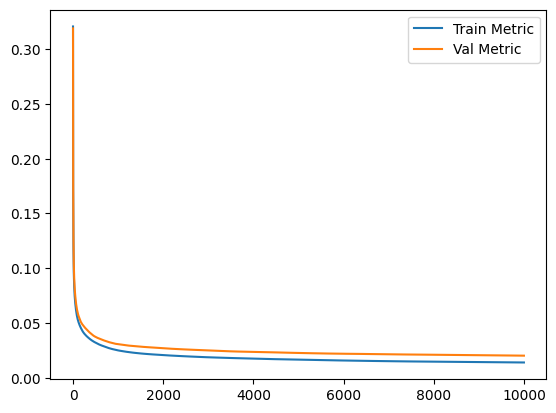

Fold 2 of 6 completed
Train Loss: 8.384261090579824e-05
Train Metric: 0.013888551715360199
Val Loss: 0.00019959907915032996
Val Metric: 0.02010942197363477


Epochs: 100%|██████████| 10000/10000 [05:47<00:00, 28.80it/s]


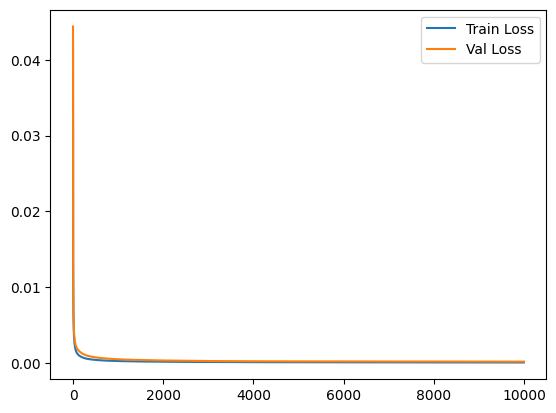

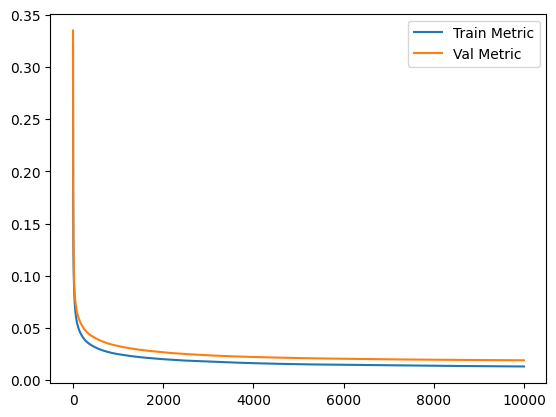

Fold 3 of 6 completed
Train Loss: 7.560306515747059e-05
Train Metric: 0.013169423368701428
Val Loss: 0.00018772902385794647
Val Metric: 0.01908327791092008


Epochs: 100%|██████████| 10000/10000 [09:41<00:00, 17.19it/s]


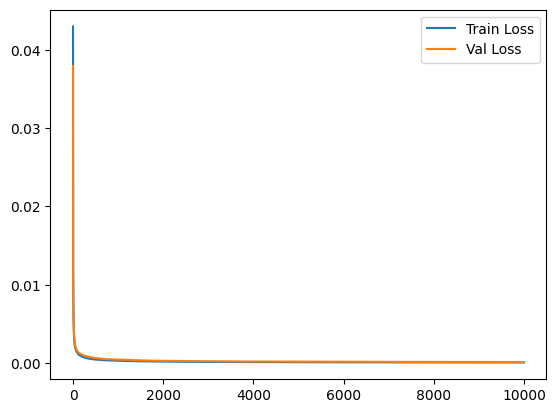

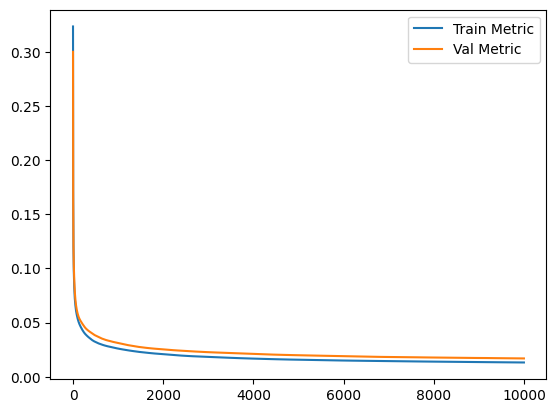

Fold 4 of 6 completed
Train Loss: 7.484394944384847e-05
Train Metric: 0.013213070224646774
Val Loss: 0.0001355713217346483
Val Metric: 0.016946231587509502


Epochs: 100%|██████████| 10000/10000 [09:22<00:00, 17.77it/s]


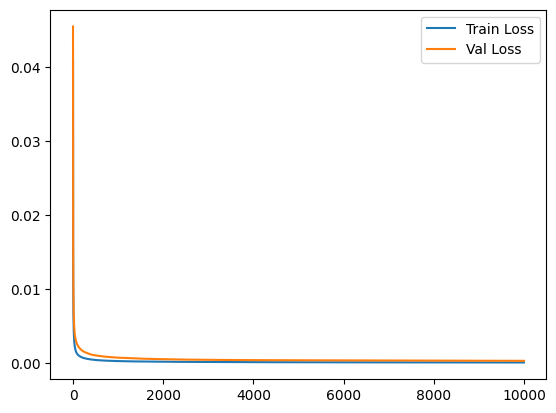

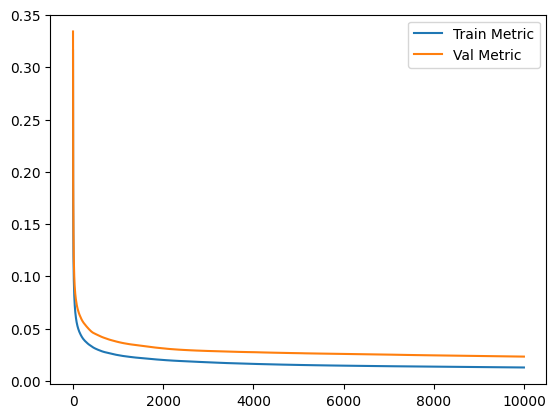

Fold 5 of 6 completed
Train Loss: 7.253047221490474e-05
Train Metric: 0.012918154804618276
Val Loss: 0.00029452836473062776
Val Metric: 0.023316616185007747


Epochs: 100%|██████████| 10000/10000 [09:25<00:00, 17.69it/s]


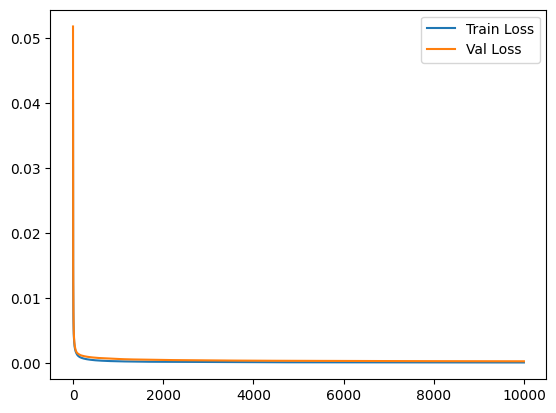

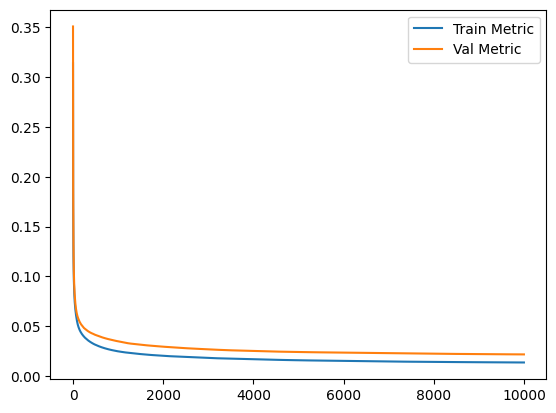

Fold 6 of 6 completed
Train Loss: 8.194401305305854e-05
Train Metric: 0.013694269676595273
Val Loss: 0.00026704782711144766
Val Metric: 0.021796436978647457
Statistics: {'tr_loss': 7.719952514341953e-05, 'tr_metric': 0.013338273002580482, 'val_loss': 0.00020682321539431444, 'val_metric': 0.019923929559788087}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.9) 0.01


Epochs:  43%|████▎     | 4263/10000 [03:37<04:52, 19.58it/s]


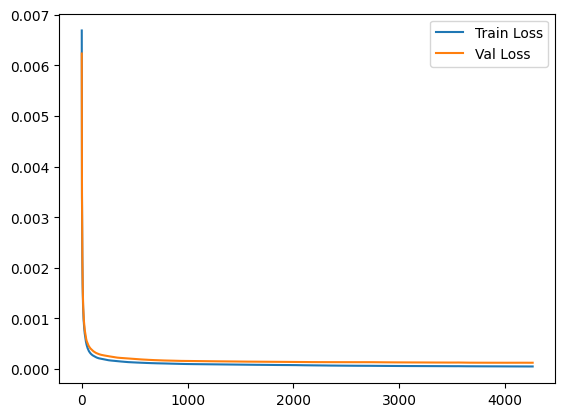

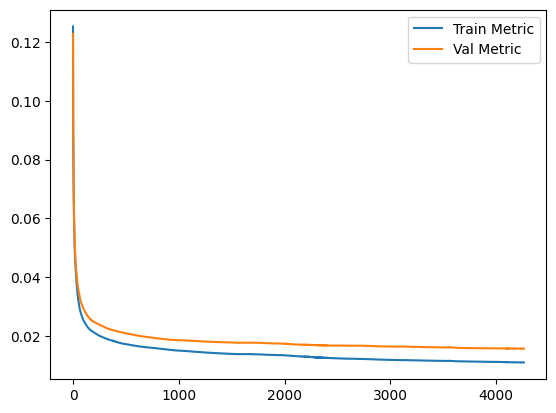

Fold 1 of 6 completed
Train Loss: 5.157990528308452e-05
Train Metric: 0.011114849684365845
Val Loss: 0.00012356769592492299
Val Metric: 0.015724382428421155


Epochs: 100%|██████████| 10000/10000 [06:55<00:00, 24.05it/s]


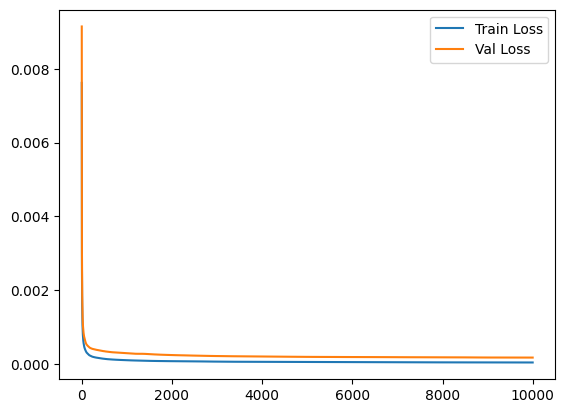

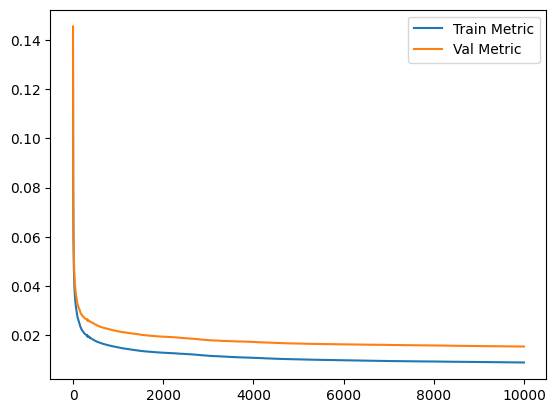

Fold 2 of 6 completed
Train Loss: 3.387162799140124e-05
Train Metric: 0.008881922548963441
Val Loss: 0.00016676817208052425
Val Metric: 0.015367289794249539


Epochs: 100%|██████████| 10000/10000 [04:56<00:00, 33.78it/s]


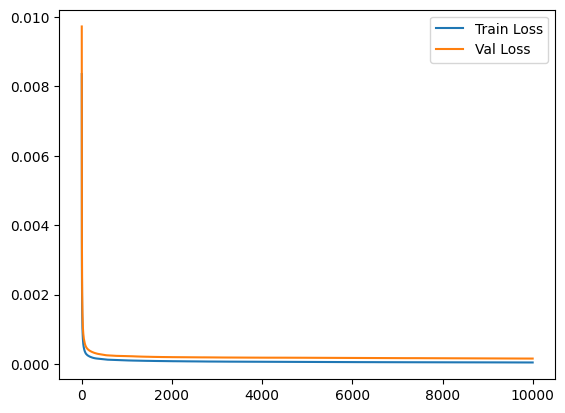

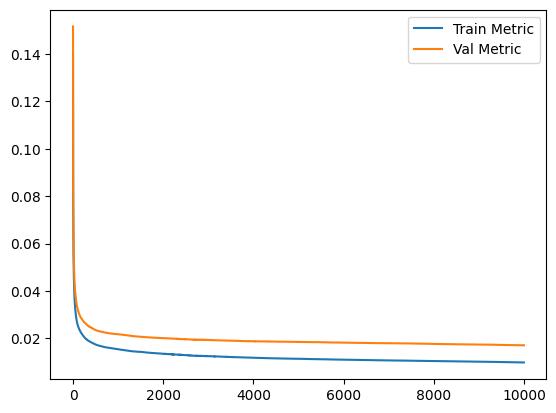

Fold 3 of 6 completed
Train Loss: 4.20123873614146e-05
Train Metric: 0.009832753373094095
Val Loss: 0.000154610575438682
Val Metric: 0.017087614755619606


Epochs:  85%|████████▌ | 8533/10000 [04:10<00:43, 34.02it/s]


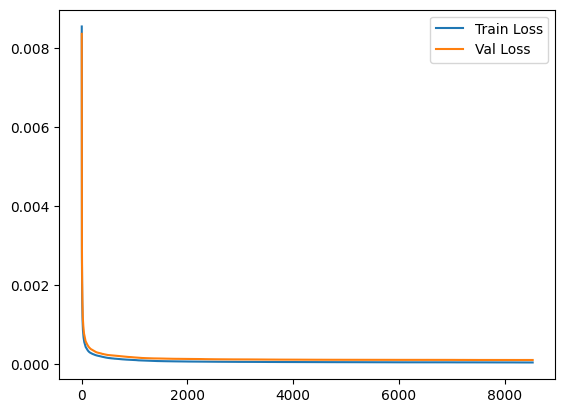

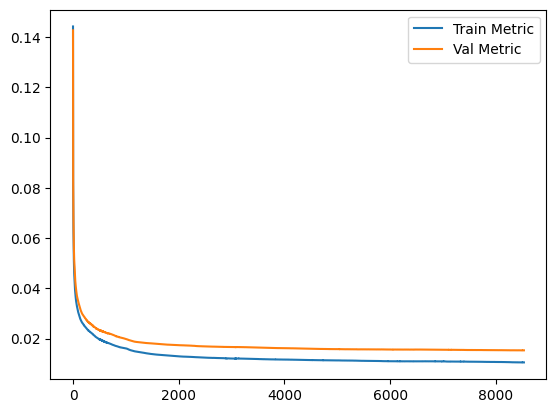

Fold 4 of 6 completed
Train Loss: 4.642299207367199e-05
Train Metric: 0.010546567379893648
Val Loss: 0.00010832256067250797
Val Metric: 0.015294008623735124


Epochs:  41%|████      | 4086/10000 [02:01<02:55, 33.75it/s]


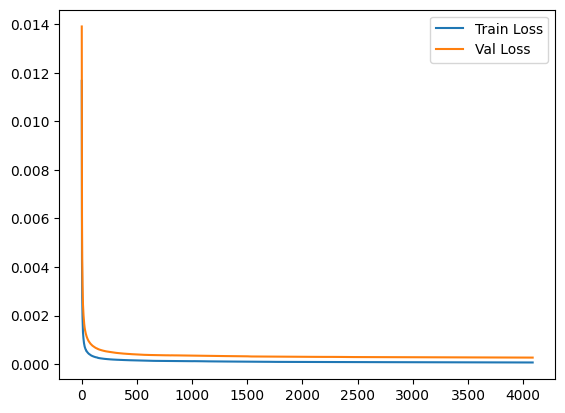

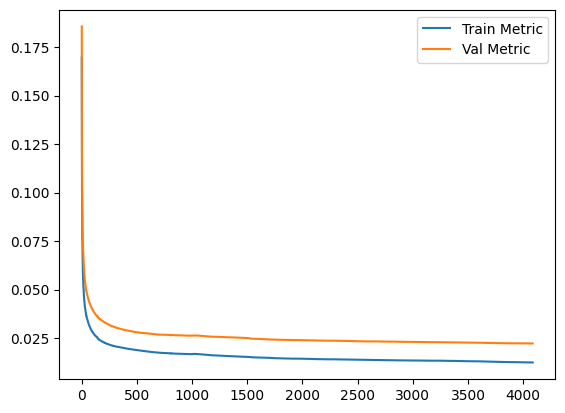

Fold 5 of 6 completed
Train Loss: 6.771247652838071e-05
Train Metric: 0.012696231727562282
Val Loss: 0.0002651641924790653
Val Metric: 0.022364189096890294


Epochs:  92%|█████████▏| 9235/10000 [04:34<00:22, 33.60it/s]


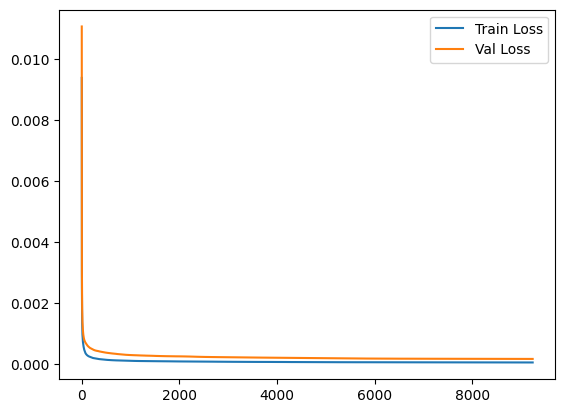

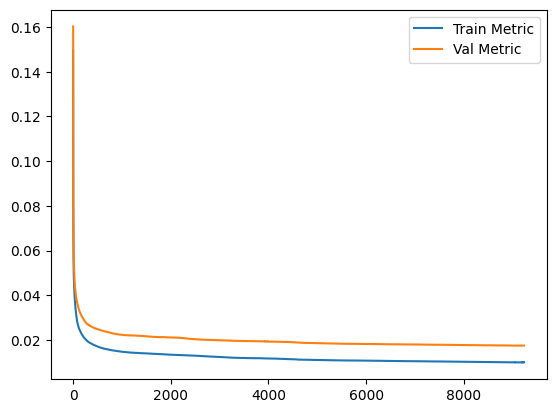

Fold 6 of 6 completed
Train Loss: 4.20825914971425e-05
Train Metric: 0.010023461690617491
Val Loss: 0.00015774357709465788
Val Metric: 0.017497185313381035
Statistics: {'tr_loss': 4.728033012251593e-05, 'tr_metric': 0.01051596440074947, 'val_loss': 0.0001626961289483934, 'val_metric': 0.017222445002049457}




Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.9) 0.001


Epochs: 100%|██████████| 10000/10000 [04:55<00:00, 33.82it/s]


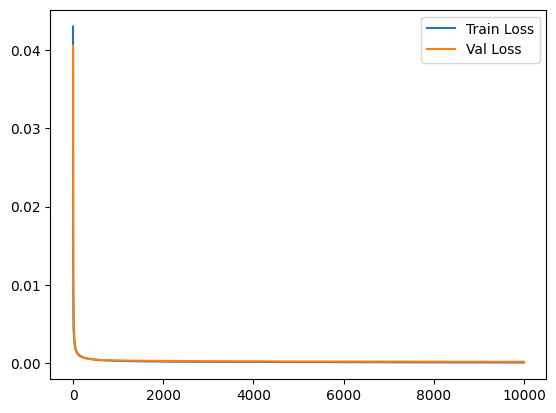

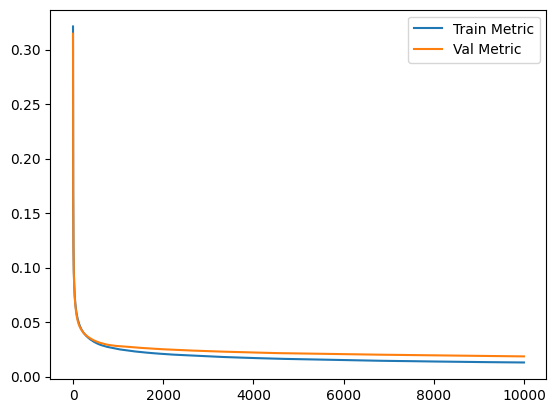

Fold 1 of 6 completed
Train Loss: 7.201597361980378e-05
Train Metric: 0.012961757538564043
Val Loss: 0.0001665085916811198
Val Metric: 0.018551698525933247


Epochs: 100%|██████████| 10000/10000 [04:57<00:00, 33.58it/s]


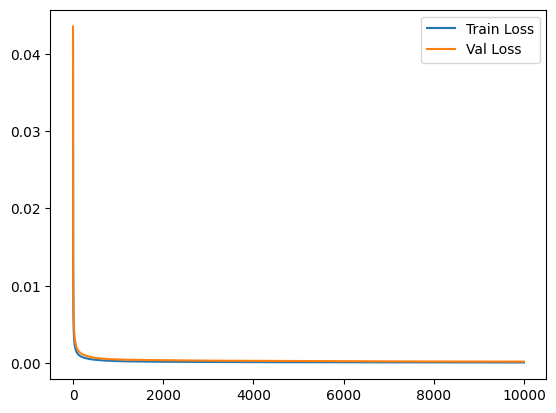

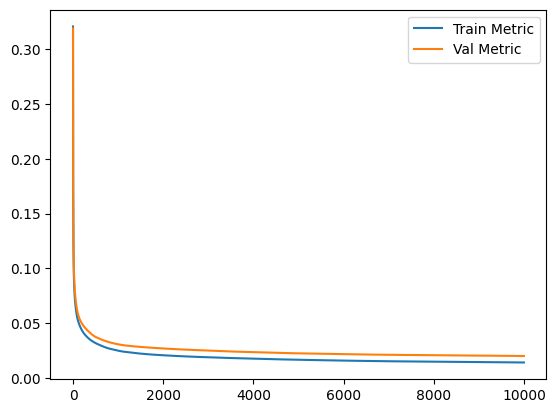

Fold 2 of 6 completed
Train Loss: 8.533402587145706e-05
Train Metric: 0.014048541708457329
Val Loss: 0.00019844651576852226
Val Metric: 0.019955440273510185


Epochs: 100%|██████████| 10000/10000 [04:56<00:00, 33.75it/s]


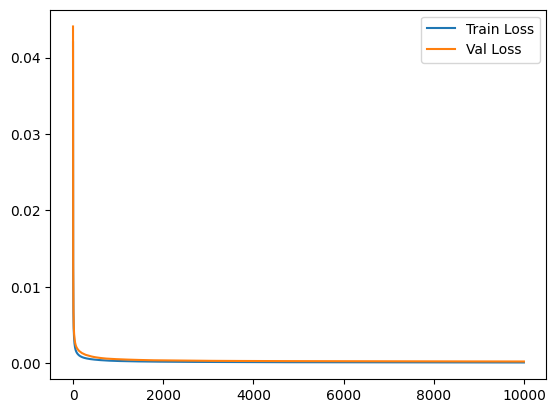

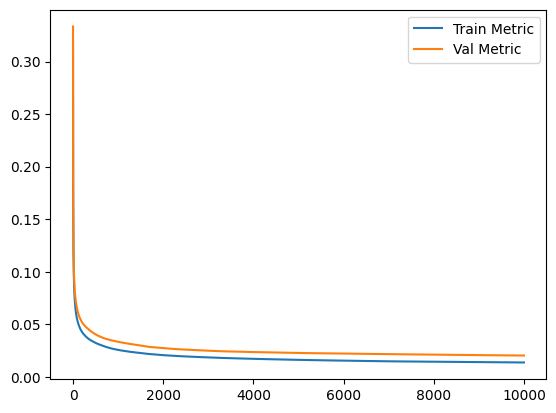

Fold 3 of 6 completed
Train Loss: 7.967877913113307e-05
Train Metric: 0.0135414562822733
Val Loss: 0.000209870405350455
Val Metric: 0.020155287810984697


Epochs: 100%|██████████| 10000/10000 [04:57<00:00, 33.64it/s]


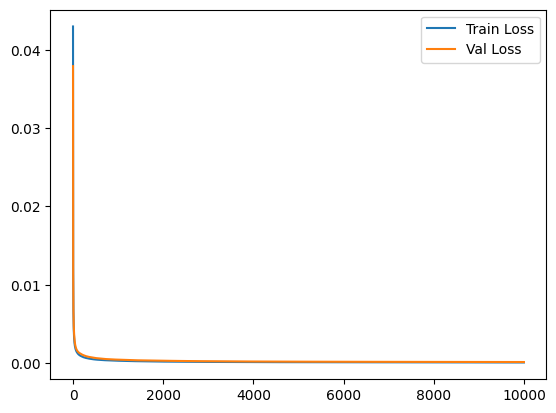

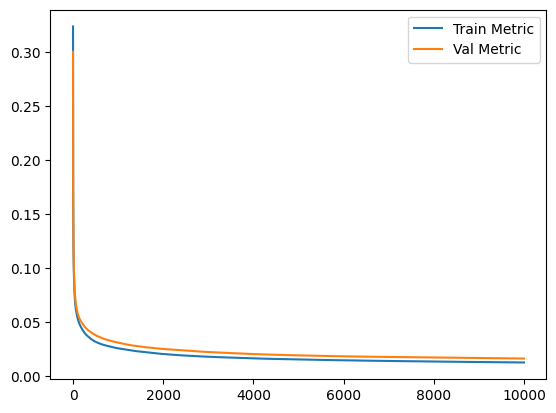

Fold 4 of 6 completed
Train Loss: 7.140259664681235e-05
Train Metric: 0.012930267423576657
Val Loss: 0.0001303166827850456
Val Metric: 0.016569560810118178


Epochs: 100%|██████████| 10000/10000 [04:57<00:00, 33.64it/s]


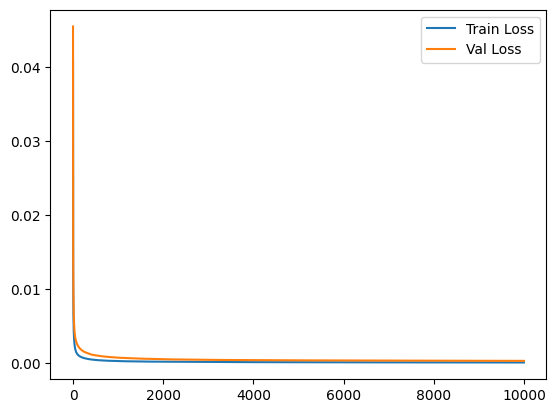

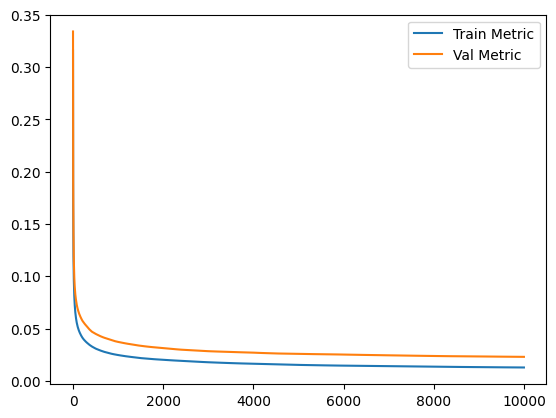

Fold 5 of 6 completed
Train Loss: 7.206043540461918e-05
Train Metric: 0.01281117648055863
Val Loss: 0.0002891829643030704
Val Metric: 0.02297078013845011


Epochs: 100%|██████████| 10000/10000 [04:56<00:00, 33.69it/s]


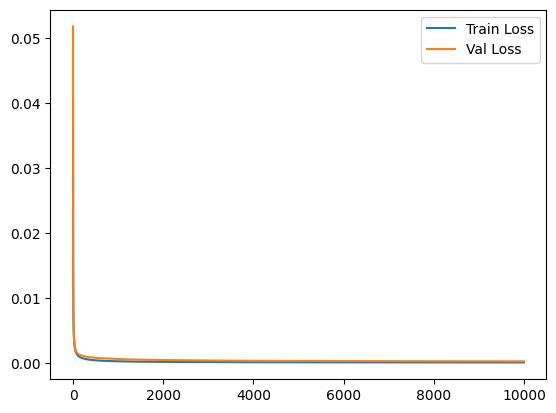

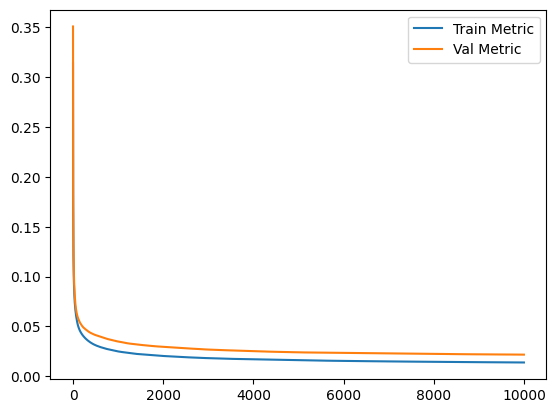

Fold 6 of 6 completed
Train Loss: 8.441928311213018e-05
Train Metric: 0.013824253664844707
Val Loss: 0.00025956328901082247
Val Metric: 0.021690289005799918
Statistics: {'tr_loss': 7.748518229765926e-05, 'tr_metric': 0.013352908849712443, 'val_loss': 0.00020898140814983924, 'val_metric': 0.019982176094132723}




Combination: [32, 32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.9) 0.01


Epochs:   4%|▍         | 446/10000 [00:20<07:16, 21.88it/s]


KeyboardInterrupt: 

In [8]:
hyperparameters = {
    'layers_sizes': [[32, 32, 3], [32,32,32,3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-6, 1e-8],
    'momentums': [('Nesterov', 0.9), ('Standard', 0.9)],
    'etas': [1e-2, 1e-3],
}

data_to_csv = grid_search(
    hyperparams=hyperparameters,
    X=X_train,
    y=y_train,
    k=6,
    metric=MEE(),
    loss=MSE(1),
    seed=6,
    verbose=True
)



In [ ]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [ ]:
# reshape ytrain eliminating last shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_train.shape

In [ ]:
# reshape Xtrain eliminating last shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_train.shape

In [ ]:
# use scikit-lear to make regression in 3d
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    solver='sgd',
    alpha=0,
    batch_size=1,
    learning_rate_init=1e-3,
    max_iter=2500,
    shuffle=True,
    random_state=6,
    verbose=True,
    momentum=0,
    beta_1= 0,
    beta_2= 0.,
    epsilon= 1,
    validation_fraction = 0,
    nesterovs_momentum=False
)

mlp.fit(X_train, y_train)
# print the learning curve
plt.plot(mlp.loss_curve_)
plt.show()

# print the mean error
print(MEE()(y_train, mlp.predict(X_train)))

In [ ]:
import itertools

# Define the hyperparameters as dictionaries
hyperparameters = {
    'losses': ["MSE"],
    'layers_sizes': [[32,32,3],[16,16,16,3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-6, 1e-8],
    'momentums': [('Nesterov', 1e-4), ('Standard', 1e-4)],
    'etas': [1e-4]
}

# Create a list of all the possible combinations using itertools.product
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

all_dics = []
# Print the result or use it as needed
for combination in hyperparameter_combinations:
    hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
    print(hyperparameter_dict)
    all_dics.append(hyperparameter_dict)

In [ ]:
for i in all_dics:
    print(*i.values())

In [ ]:
losses_ = "MSE"

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    
    print(layers_sizes_)
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")

In [ ]:
data_to_csv = [["Loss func","Size", "Activation", "Starting", "Range", "Regularizer", "lambda", "Momentum", "Eta", "tLoss", "tMetric", "vLoss", "vMetric"]]

In [ ]:
seed = 3
data_to_csv = [[]]
losses_ = "MSE"

for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=len(layers_sizes_),
        layers_size=layers_sizes_,
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=10000,
        patience=250,
        seed=seed,
        metric=MEE(),
        comb=combination
        )
    print(statistics)
    print("\n\n\n")
    data_to_csv.append(list(combination.values()) + list(statistics.values()))


In [ ]:
data_to_csv

In [11]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    